# 从零开始实现线性回归
包括：数据流水线、模型、损失函数、小批量随机梯度下降优化器

**在Pycharm上面编程的话，想要看到图像记得加上d2l.plt.show()！**

In [1]:
%matplotlib inline
import random # 随机梯度下降，初始化权重
import torch
from d2l import torch as d2l

## 1. 构造数据集 
根据带有噪声的线性模型构造一个数据集。
我们使用线性模型参数$\vec{w}=[2,-3.4]^T$，$b=4.2$和噪声$\epsilon$生成数据集及其标签：
$$
y=X\vec{w}+b+\epsilon
$$
X就是一些随机数。

In [20]:
# 根据w，b生成n个example，并返回数据x，以及对应的y
def synthetic_data(w, b, num_examples):
    #torch.normal生成一个服从正态分布的张量
    # 均值为0，方差为1，(num_examples, len(w)) 为形状，一个特征对应一个权重，所以特征数为len(w)，一行是一个样本
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(X, w) + b # 等价于 X@w + b 。y.shape为(num_examples,1)
    print(X.shape, y.shape)
    y += torch.normal(0, 0.01, y.shape) # 给每个x_i加一个噪音
    return X, y.reshape((-1, 1)) # 把y变为列向量返回

true_w = torch.tensor([2, -3.4]) # 两个权重，所以每个样本有两个特征
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000) # 生成1000个examples

torch.Size([1000, 2]) torch.Size([1000])


In [21]:
print(f'features:{features.shape}, labels:{labels.shape}')
print(f'features:{features[0]}, labels:{labels[0]}')

features:torch.Size([1000, 2]), labels:torch.Size([1000, 1])
features:tensor([-1.6131,  0.9271]), labels:tensor([-2.1523])


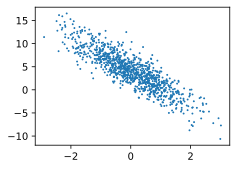

In [22]:
d2l.set_figsize()
# 一些版本的Pytorch中，需要将张量从计算图里detach出来才能转为numpy
d2l.plt.scatter(features[:,1].detach().numpy(), labels.detach().numpy(), 1) # 最后这个1是点的大小

## 2.定义data_iter 按批处理数据
定义data_iter函数，该函数接收批量大小，特征矩阵和label向量作为输入，生成大小为batch_size的小批量

In [23]:
def data_iter(batch_size, features, labels):
    # 直接把所有Data放入内存了，如果data特别多内存就爆了
    num_examples = len(features) # 1000
    indices = list(range(num_examples)) # [0, 1, ..., 999]
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        # [0,num_examples=1000),每一次处理一个batch
        # 一次循环就是batch_size个examples
        
        # 获取要这一批次数据的index，indices这个list中存的是打乱顺序的examples的索引
        # 每次取一批，或者如果剩下的样本数量不足一批就取剩下的
        batch_indices = torch.tensor(indices[i:min(i+batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices] # 返回了一个iterator

batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[-0.1261, -1.8023],
        [ 0.2107, -0.0993],
        [-0.9889, -0.1903],
        [ 0.2902, -0.8332],
        [-1.7705,  1.1971],
        [ 0.2838, -0.6957],
        [ 0.2982,  0.0975],
        [ 0.5236, -0.4823],
        [-0.1905, -0.2023],
        [ 0.5526,  1.0354]]) 
 tensor([[10.0659],
        [ 4.9620],
        [ 2.8651],
        [ 7.6092],
        [-3.4089],
        [ 7.1283],
        [ 4.4487],
        [ 6.8912],
        [ 4.4844],
        [ 1.7926]])


## 3.定义 初始化模型参数

In [24]:
w = torch.normal(0, 0.01, size=(2, 1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)
w, b

(tensor([[-0.0057],
         [ 0.0083]], requires_grad=True),
 tensor([0.], requires_grad=True))

## 4.定义模型

In [25]:
def linreg(X, w, b):
    '''    Linear regression    '''
    return torch.matmul(X, w) + b

## 5.定义损失函数

In [26]:
def square_loss(y_hat, y):
    ''' 均方误差 '''
    return (y_hat - y.reshape(y_hat.shape))**2 / 2

## 6.定义优化算法 optimizer

为什么更新param参数的语句要写在with torch.no_grad()语句里？

因为之前loss.backward()已经将计算图销毁，之后再对params这个叶子结点做任何操作，都会产生新的计算图，而我们就是很简单的对参数进行更新而已，不需要产生新的计算图去求偏导，所以要阻断计算图的生成就要用到with torch.no_grad()语句。
___
之后再进行前向传播的时候生成新的计算图就可以了，其实要想搞懂这里就要真正的明白PyTorch的计算图，以及反向传播的时候只能对叶子结点求偏导

In [27]:
def sgd(params, lr, batch_size):
    ''' 小批量梯度下降。'''
    # 更新参数不需要梯度计算，算完loss反向传播才需要梯度
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size # 计算loss那除batch_size求均值和这里除是完全一样的
            
            param.grad.zero_()

## 7.训练过程

In [28]:
lr = 0.03 # lr太大loss可能会出现nan
num_epochs = 3
net = linreg
loss = square_loss

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y) # 小批量上的损失
        # `l`形状是(batch_size, 1)的向量，不是标量。所以要求和再backward
        l.sum().backward()
        sgd([w,b], lr, batch_size) # 使用参数的梯度更新参数
    # 训练玩一个epoch，评估一下模型
    # 
    with torch.no_grad():
        train_loss = loss(net(features, w, b), labels) # 这里就是将所有的样本，和对应的label传入模型计算一下训练损失，这里是没有验证集
        print(f'Epoch {epoch+1}/{num_epochs}, train loss: {float(train_loss.mean()):f}')

Epoch 1/3, train loss: 0.037250
Epoch 2/3, train loss: 0.000139
Epoch 3/3, train loss: 0.000051


因为是人工构造的数据集，可以看到 真实的w b。真实w b就是要学的目标

In [30]:
print(f'真实的： true_w={true_w}, true_b={true_b}')
print(f'学到的： w={w}, b={b}')
print(f'w的估计误差：{true_w - w.reshape(true_w.shape)}, b的估计误差{true_b - b}')

真实的： true_w=tensor([ 2.0000, -3.4000]), true_b=4.2
学到的： w=tensor([[ 1.9999],
        [-3.3998]], requires_grad=True), b=tensor([4.1993], requires_grad=True)
w的估计误差：tensor([ 0.0001, -0.0002], grad_fn=<SubBackward0>), b的估计误差tensor([0.0007], grad_fn=<RsubBackward1>)


# 线性回归的简洁实现 —— 使用torch.nn

In [44]:
import numpy as np
import torch
from torch.utils import data
from d2l import torch as d2l

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = d2l.synthetic_data(true_w, true_b, 1000)

load 数据

In [45]:
def load_array(data_arrays, batch_size, is_train=True):
    # TensorDataset是Dataset的子类，内部已经实现了__len__, __getitem__
    # 可以直接用，每次返回所有张量在同一索引处元素组成的tuple，不需要自定义复杂的处理
    # Dataset就需要自己去实现这个抽象类
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)

batch_size=10
data_iter = load_array( (features, labels), batch_size)

next(iter(data_iter))

[tensor([[ 0.1152,  1.8866],
         [ 0.3329,  0.0352],
         [-0.0337, -0.4361],
         [-0.5414,  0.8641],
         [ 0.8509,  0.7448],
         [ 0.0111,  0.0687],
         [-0.7312,  0.0211],
         [ 0.2159,  0.5223],
         [ 1.4650, -0.5745],
         [ 0.0836,  0.1750]]),
 tensor([[-1.9852],
         [ 4.7439],
         [ 5.6082],
         [ 0.1772],
         [ 3.3914],
         [ 3.9779],
         [ 2.6600],
         [ 2.8656],
         [ 9.0728],
         [ 3.7620]])]

定义net

In [46]:
from torch import nn

net = nn.Sequential(nn.Linear(2, 1))

随机初始化模型参数

In [47]:
# 只有1层，所以net[0]，若多层直接用09_Softmax实现中简洁实现那部分的初始化方法
net[0].weight.data.normal_(0, 0.01) # w  .normal_()是使用正态分布，替换掉当前data里的值，赋值操作
net[0].bias.data.fill_(0) # b

tensor([0.])

定义loss, MSE loss也是平方L2范数

In [48]:
loss = nn.MSELoss()

定义optimizer

In [49]:
trainer = torch.optim.SGD(net.parameters(), lr=0.03)

训练模块

In [50]:
num_epochs = 3
for epoch in range(num_epochs):
    for X, y in data_iter:
        l = loss(net(X), y) # net不需要传入参数了，每一层的参数都已经在里面了
        
        trainer.zero_grad()
        l.backward() # pytorch的loss已经做了sum，所以不用手动sum了
        trainer.step() # 更新梯度
        
    l = loss(net(features), labels)
    print(f'Epoch {epoch+1}/{num_epochs}, train loss: {l:f}')

Epoch 1/3, train loss: 0.000216
Epoch 2/3, train loss: 0.000096
Epoch 3/3, train loss: 0.000095
